# Classify Single-cell Differentiation States Based on AP-1 Protein Levels

Natacha Comandante-Lou

Nov, 2021

In [1]:
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

import shap
import random
from time import time

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from plotnine import *
import colorcet as cc
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

### 1. Read sampled data:

In [3]:
file_path = 'Sampled_Gated_Cells_by_Diff_States.csv'
df = pd.read_csv(file_path)
df.shape
df

cellline_id cellline  condition_id condition  timepoint_id  time  \
0              13    A101D             1      DMSO             1  24 h   
1              13    A101D             1      DMSO             1  24 h   
2              13    A101D             1      DMSO             1  24 h   
3              13    A101D             1      DMSO             1  24 h   
4              13    A101D             1      DMSO             1  24 h   
...           ...      ...           ...       ...           ...   ...   
9990            2   WM902B             1      DMSO             1  24 h   
9991            2   WM902B             1      DMSO             1  24 h   
9992            2   WM902B             1      DMSO             1  24 h   
9993            2   WM902B             1      DMSO             1  24 h   
9994            2   WM902B             1      DMSO             1  24 h   

      rep_id      cFos  Phospho_cFos      Fra1  ...       AXL  \
0          2  2.734755      2.188795  2.720178  ...  3.166495   
1          2  2.590382      2.143408  2.902303  ...  2.807193   
2          2  2.608672      2.175015  2.779878  ...  2.881768   
3          2  2.842560      2.338525  2.371135  ...  2.430825   
4          2  2.779544      2.279619  2.956393  ...  3.334671   
...      ...       ...           ...       ...  ...       ...   
9990       2  3.101119      3.164115  2.596159  ...  2.226242   
9991       1  2.939551      3.103736  2.748392  ...  2.100181   
9992       2  2.998553      2.900951  2.583290  ...  2.139879   
9993       2  2.848389      2.509009  2.650029  ...  2.144148   
9994       1  3.024468      3.137642  2.843295  ...  2.266885   

      Phospho_Erk_Rabbit  Phospho_JNK  Phospho_S6  p65_NFkB  AXL.class  \
0               2.479791     2.529652    2.797144  1.315188          H   
1               2.349449     2.430802    1.504742  1.140844          H   
2               2.327886     2.303425    2.510372  1.112257          H   
3               2.511839     2.324649    2.567266  0.989644          H   
4               2.573126     2.447837    3.078970  1.288887          H   
...                  ...          ...         ...       ...        ...   
9990            2.911179     1.749836    2.731936  0.962731          L   
9991            2.798399     2.123877    2.550582  1.163105          L   
9992            2.829077     2.030710    2.458526  0.977424          L   
9993            2.659623     1.904505    2.604455  0.841874          L   
9994            2.926001     2.058974    2.916647  1.080064          L   

      NGFR.class  MiTF.class  Sox10.class  Diff.class  
0              L           L            L  U.NGFR_Low  
1              L           L            L  U.NGFR_Low  
2              L           L            L  U.NGFR_Low  
3              L           L            L  U.NGFR_Low  
4              L           L            L  U.NGFR_Low  
...          ...         ...          ...         ...  
9990           L           H            H           M  
9991           L           H            H           M  
9992           L           H            H           M  
9993           L           H            H           M  
9994           L           H            H           M  

[9995 rows x 39 columns]

### 2. List of AP-1's, check categories order

In [4]:
AP1s = ["cFos","Phospho_cFos","Fra1","Phospho_Fra1","Fra2",
         "cJun","Phospho_cJun","JunB", "JunD",
         "Phospho_ATF1","ATF2","Phospho_ATF2","ATF3","ATF4","Phospho_ATF4","ATF5","ATF6"]
X = df[AP1s]
y = pd.Series(df["Diff.class"], dtype="category")
y = y.cat.reorder_categories(['M','T','N','U.NGFR_Low'])#Melanocytic, Transitory, Neural crest-like, Undifferentiated
y

0       U.NGFR_Low
1       U.NGFR_Low
2       U.NGFR_Low
3       U.NGFR_Low
4       U.NGFR_Low
           ...    
9990             M
9991             M
9992             M
9993             M
9994             M
Name: Diff.class, Length: 9995, dtype: category
Categories (4, object): ['M', 'T', 'N', 'U.NGFR_Low']

### 3. Split training and testing data

In [9]:

for diff_class in y.cat.categories:
    
    dff = df[df['Diff.class']==diff_class]
    
    dff_test = dff.groupby('cellline').sample(frac = 0.20,replace=False, random_state = 100) #Taking 20% of the cells as test set for each cell line
    dff_train=dff.drop(dff_test.index)
    
    if diff_class==y.cat.categories[0]:
        df_test = dff_test
        df_train = dff_train
    else:
        df_test = pd.concat([df_test,dff_test])
        df_train = pd.concat([df_train,dff_train])
        
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

Glyph 26 missing from current font.
Glyph 26 missing from current font.
Glyph 26 missing from current font.


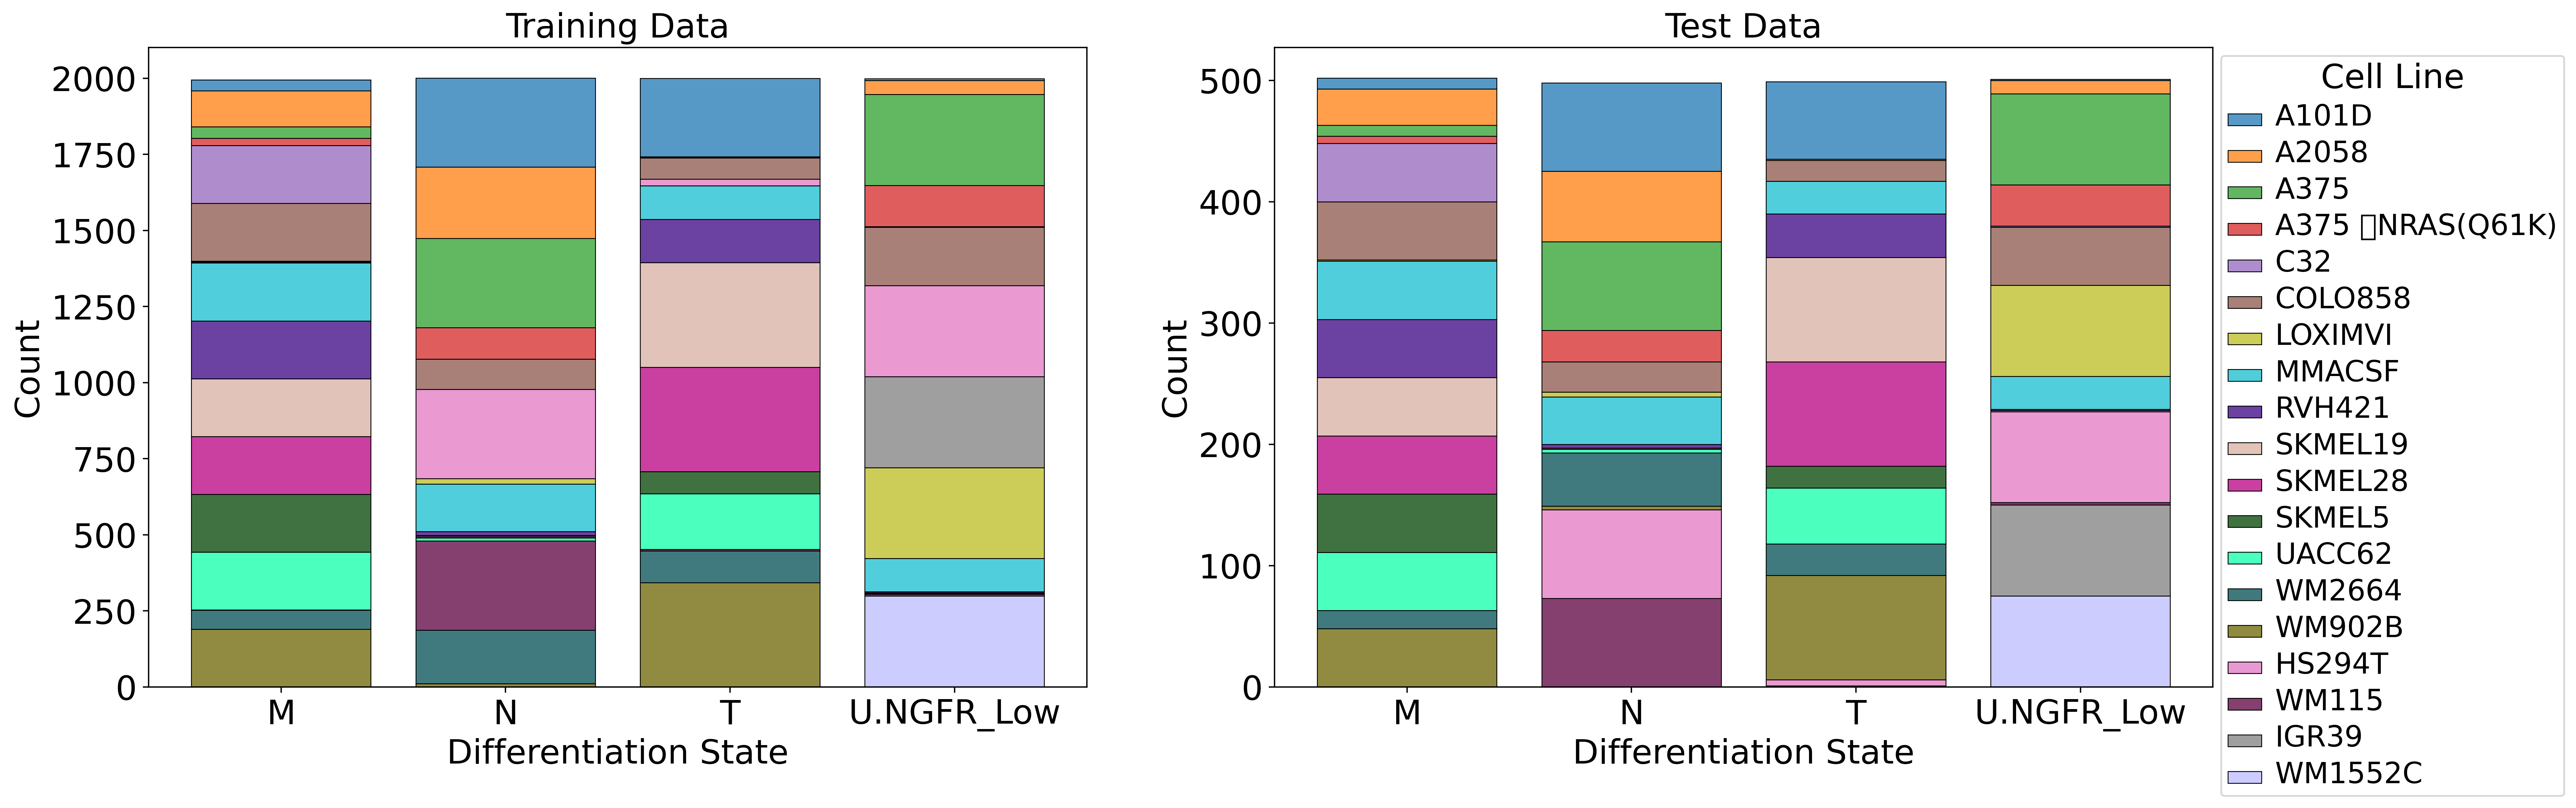

In [11]:
#Get count
count_train = df_train.groupby(['Diff.class','cellline']).size().reset_index(name='counts')
count_train['Diff.class'].astype("category").cat.reorder_categories(['M','T','N','U.NGFR_Low'])
count_test = df_test.groupby(['Diff.class','cellline']).size().reset_index(name='counts')
count_test['Diff.class'].astype("category").cat.reorder_categories(['M','T','N','U.NGFR_Low'])

#Plot cell line representations of training and testing data across differentiation states
plt.subplots(1,2,figsize=(22,7),dpi = 200)

cmap = cc.glasbey_category10
res = {df['cellline'].unique()[i]: cmap[i] for i in range(len(df['cellline'].unique()))}

plt.subplot(1,2,1)
ax = sns.histplot(count_train, x='Diff.class', hue='cellline', weights='counts',
             multiple='stack', palette=res, shrink=0.8,linewidth=0.5)
ax.set_ylabel('Count',fontsize = 20)
ax.set_xlabel('Differentiation State',fontsize = 20)
ax.set_title('Training Data',fontsize = 20)
ax.legend([],[], frameon=False)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.subplot(1,2,2)
ax = sns.histplot(count_test, x='Diff.class', hue='cellline', weights='counts',
             multiple='stack', palette=res, shrink=0.8,linewidth=0.5)
ax.set_ylabel('Count',fontsize = 20)
ax.set_xlabel('Differentiation State',fontsize = 20)
ax.set_title('Test Data',fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# Fix the legend so it's not on top of the bars.
legend = ax.get_legend()
legend.set_bbox_to_anchor((1,1))
legend.set_title('Cell Line',prop={'size':20})
ltext  = legend.get_texts()
plt.setp(ltext, fontsize='xx-large')

plt.savefig('Train_Test_Data_Cell_Line_Counts.pdf', format='pdf')

In [13]:
X_train = df_train[AP1s]
X_train.reset_index(drop=True, inplace=True)
y_train = pd.Series(df_train["Diff.class"], dtype="category")
y_train.reset_index(drop=True, inplace=True)
y_train = y_train.cat.reorder_categories(['M','T','N','U.NGFR_Low'])


X_test = df_test[AP1s]
X_test.reset_index(drop=True, inplace=True)
y_test = pd.Series(df_test["Diff.class"], dtype="category")
y_test.reset_index(drop=True, inplace=True)
y_test = y_test.cat.reorder_categories(['M','T','N','U.NGFR_Low'])



### 4. Define Cross Validation

In [15]:
seed_id = 42
random.seed(seed_id)
cv = StratifiedShuffleSplit(n_splits = 10,test_size = 0.2,random_state=seed_id)

### 5. Model Training and Optimization

#### Varying max_depth

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

max_depths = np.linspace(1, 50, 50, endpoint=True)
train_acc_results = []
test_acc_results = []
train_roc_results = []
test_roc_results = []

for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, random_state = seed_id, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    
    #accuracy
    train_acc = cross_val_score(rf, X_train_scaled, y_train, cv=cv,scoring= "accuracy")
    train_acc_results.append( train_acc.mean())
    
    test_acc = accuracy_score(y_test, rf.predict(X_test_scaled))
    test_acc_results.append(test_acc)
    
    #roc auc
    train_roc = cross_val_score(rf, X_train_scaled, y_train, cv=cv,scoring= "roc_auc_ovr")
    train_roc_results.append(train_roc.mean())
    
    y_pred_mat = label_binarize(rf.predict(X_test_scaled),classes = ["M","T","N","U.NGFR_Low"])
    y_test_mat = label_binarize(y_test,classes = ["M","T","N","U.NGFR_Low"])
    test_roc = roc_auc_score(y_test_mat, y_pred_mat,multi_class='ovr')
    test_roc_results.append(test_roc)
    



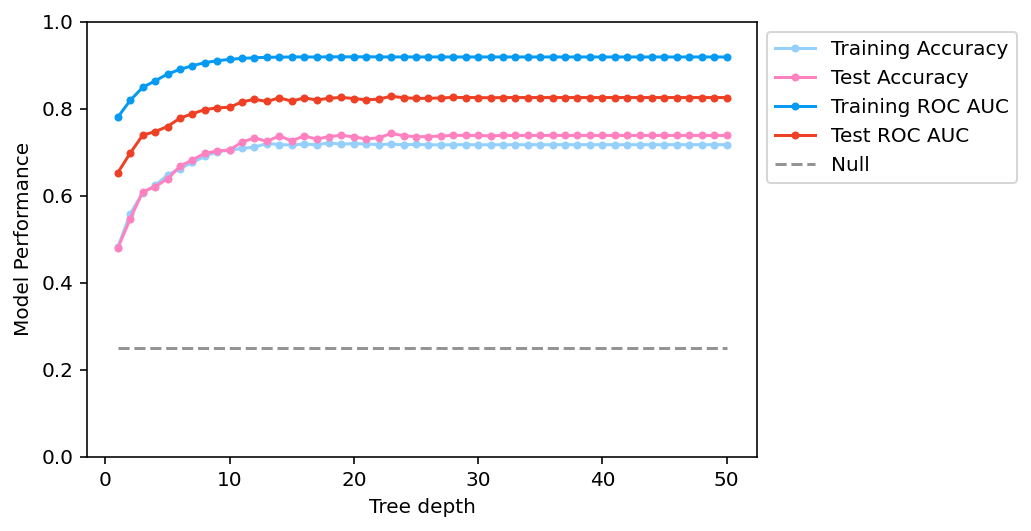

In [63]:
null = 1/len(y_train.unique())
line1, = plt.plot(max_depths, train_acc_results, '.-',color = 'xkcd:light blue', label="Training Accuracy")
line2, = plt.plot(max_depths, test_acc_results, '.-',color = 'xkcd:pink', label="Test Accuracy")
line3, = plt.plot(max_depths, train_roc_results, '.-',color = 'xkcd:azure', label="Training ROC AUC")
line4, = plt.plot(max_depths, test_roc_results, '.-',color = 'xkcd:tomato', label="Test ROC AUC")
line5, = plt.plot(max_depths, np.ones(len(max_depths),)*null,'--',color = "xkcd:grey", label = "Null")
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2,)})
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.ylabel('Model Performance')
plt.xlabel('Tree depth')
plt.ylim((0,1))

plt.savefig('RF_Optimize_max_depth.pdf', format='pdf')

max_depth_opt = 14 #optimized max_depth

#### Varying n_estimators

In [65]:
n_estimators = [10,100,1000,5000,10000]
train_acc_results = []
test_acc_results = []
train_roc_results = []
test_roc_results = []
for n_estimator in n_estimators:
    rf = RandomForestClassifier(max_depth=max_depth_opt,
                                n_estimators = n_estimator,
                                random_state = seed_id,
                                n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    
    #accuracy
    train_acc = cross_val_score(rf, X_train_scaled, y_train, cv=cv,scoring= "accuracy")
    train_acc_results.append( train_acc.mean())
    
    test_acc = accuracy_score(y_test, rf.predict(X_test_scaled))
    test_acc_results.append(test_acc)
    
    #roc auc
    train_roc = cross_val_score(rf, X_train_scaled, y_train, cv=cv,scoring= "roc_auc_ovr")
    train_roc_results.append(train_roc.mean())
    
    y_pred_mat = label_binarize(rf.predict(X_test_scaled),classes = ["M","T","N","U.NGFR_Low"])
    y_test_mat = label_binarize(y_test,classes = ["M","T","N","U.NGFR_Low"])
    test_roc = roc_auc_score(y_test_mat, y_pred_mat,multi_class='ovr')
    test_roc_results.append(test_roc)


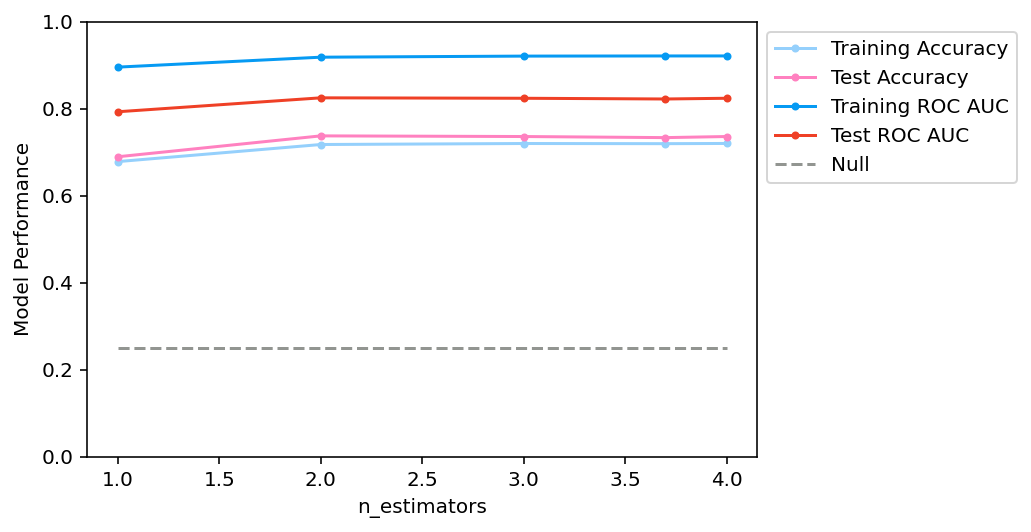

In [73]:
null = 1/len(y_train.unique())
line1, = plt.plot(np.log10(n_estimators), train_acc_results, '.-',color = 'xkcd:light blue', label="Training Accuracy")
line2, = plt.plot(np.log10(n_estimators), test_acc_results, '.-',color = 'xkcd:pink', label="Test Accuracy")
line3, = plt.plot(np.log10(n_estimators), train_roc_results,  '.-',color = 'xkcd:azure',  label="Training ROC AUC")
line4, = plt.plot(np.log10(n_estimators), test_roc_results, '.-',color = 'xkcd:tomato',  label="Test ROC AUC")
line5, = plt.plot(np.log10(n_estimators), np.ones(len(n_estimators),)*null,'--',color = "xkcd:grey",label = "Null")
#plt.legend(handler_map={line1: HandlerLine2D(numpoints=2,)})
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.ylabel('Model Performance')
plt.xlabel('n_estimators')
plt.ylim((0,1))

plt.savefig('RF_Optimize_n_estimators.pdf', format='pdf')

n_estimators_opt = 100 #optimized n_estimators

### - _Random Forest (Final Model)_ 

In [17]:
# z-score data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model training
rf = RandomForestClassifier(max_depth=max_depth_opt, #optimaized n_estimators (=100)
                            n_estimators = n_estimators_opt, #optimized max_depth (=14)
                            random_state = seed_id,
                            n_jobs=-1)

# cross validation performance on training data
train_auc = cross_val_score(rf, X_train_scaled, y_train, cv=cv,scoring= "roc_auc_ovr")
print("ROC AUC: %0.3f" % train_auc.mean())
train_accuracy = cross_val_score(rf, X_train_scaled, y_train, cv=cv,scoring= "accuracy")
print("Accuracy: %0.3f" %train_accuracy.mean())



ROC AUC: 0.918
Accuracy: 0.718


### - _Test Data Performance_ 

Accuracy: 0.738
ROC AUC: 0.825


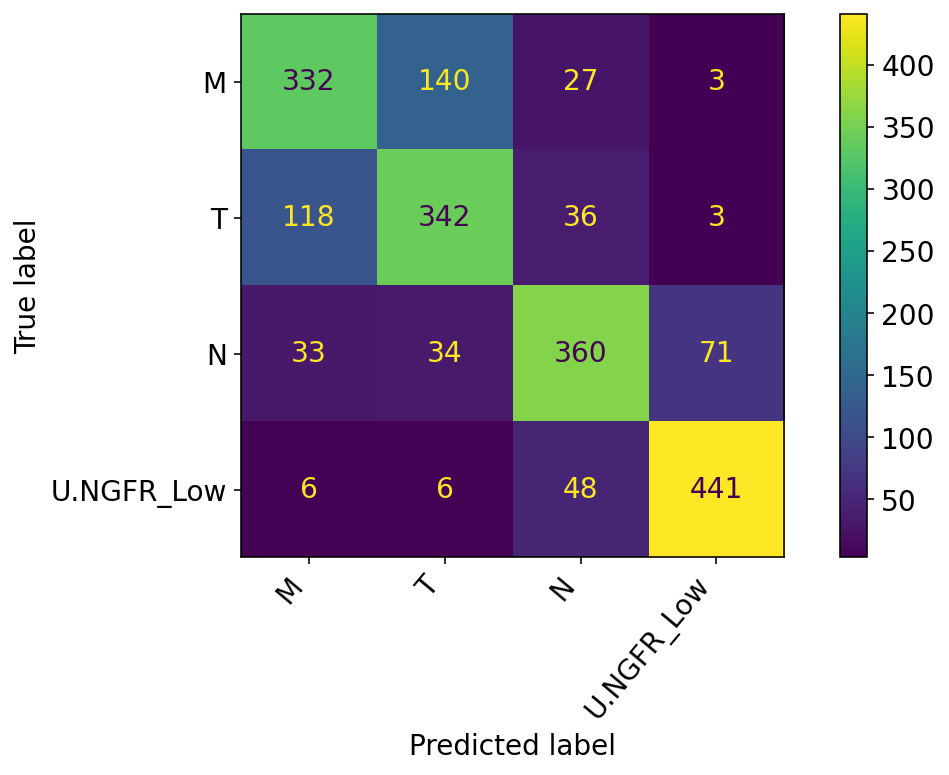

In [21]:
rf.fit(X_train_scaled,y_train)

#Calculate performance
print("Accuracy: %0.3f" % accuracy_score(y_test, rf.predict(X_test_scaled)))

y_pred_mat = label_binarize(rf.predict(X_test_scaled),classes = ["M","T","N","U.NGFR_Low"])
y_test_mat = label_binarize(y_test,classes = ["M","T","N","U.NGFR_Low"])
test_scores = roc_auc_score(y_test_mat, y_pred_mat,multi_class='ovr')


print("ROC AUC: %0.3f" % test_scores)



#confusion matrix of test data prediction
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
metrics.plot_confusion_matrix(rf, 
                        X_test_scaled, 
                        y_test, 
                        ax=axes, 
                        labels=["M", "T","N",'U.NGFR_Low'])
    
plt.sca(axes)
plt.xticks(rotation=50,ha = "right")
plt.rc('font', size=14)    
plt.savefig('Test_Confusion_Mat_M-T-N-U.pdf', format='pdf')

### 6. Explain Model using SHAP value

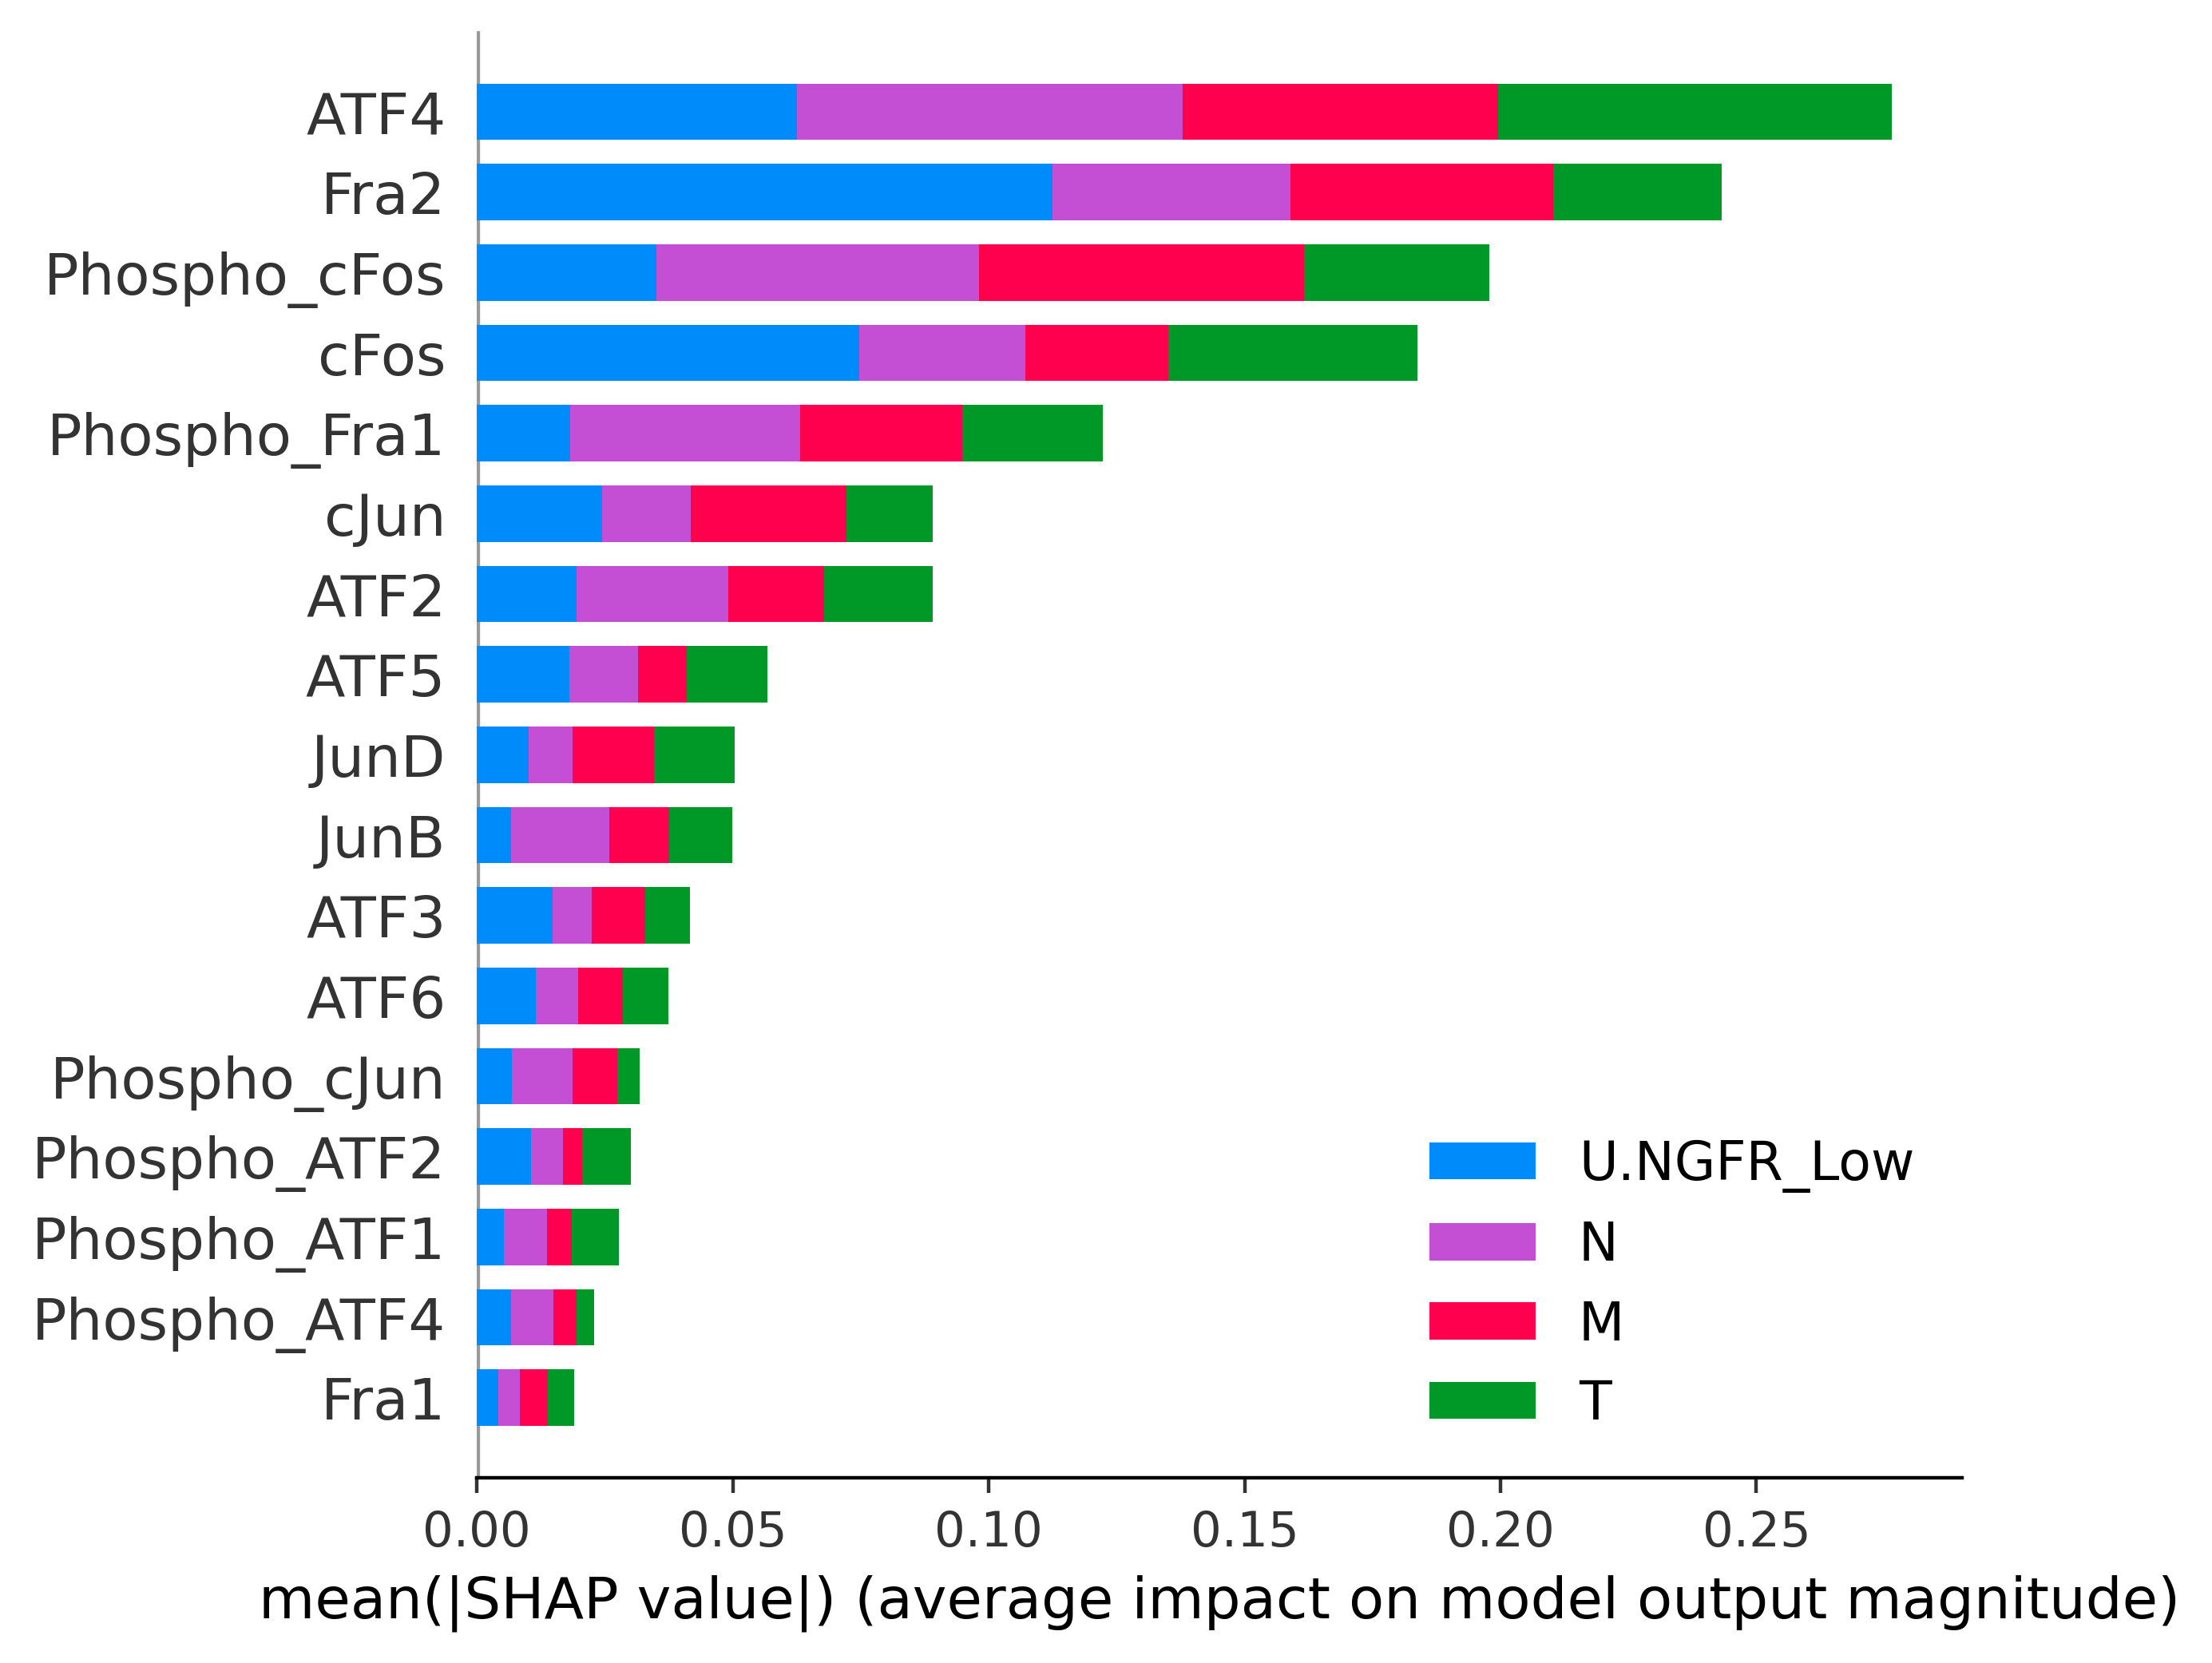

In [23]:
df_X_test_scaled = pd.DataFrame(X_test_scaled,columns=AP1s)

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(df_X_test_scaled)

plt.subplots(1,1,figsize=(6,6),dpi = 200)
shap.summary_plot(shap_values, df_X_test_scaled, plot_type="bar",class_names=rf.classes_,plot_size = None,show = False)

plt.savefig('RF_SHAP_Summary_Plot.pdf', format='pdf')

In [25]:
y_test.unique()


['M', 'T', 'N', 'U.NGFR_Low']
Categories (4, object): ['M', 'T', 'N', 'U.NGFR_Low']

In [27]:
rf.classes_

array(['M', 'N', 'T', 'U.NGFR_Low'], dtype=object)

In [33]:
#Save SHAP values for each differentiation state

df_shap_val = pd.DataFrame(shap_values[0],columns=df_X_test_scaled.columns) 

df_shap_val['SHAP_Score_Type'] = [rf.classes_[0]]*2000 #shap values for Melanocytic class

for j in np.array([2,1,3]): #shap values for Transitory, Neural crest-like and Undifferentiated class
    dff = pd.DataFrame(shap_values[j],columns=df_X_test_scaled.columns)
    
    dff['SHAP_Score_Type'] = [rf.classes_[j]]*2000
    df_shap_val = pd.concat([df_shap_val,dff])
    
df_shap_val.to_csv('RF_SHAP_Value_Output.csv')

In [35]:
df_shap_val

cFos  Phospho_cFos      Fra1  Phospho_Fra1      Fra2      cJun  \
0     0.017223     -0.059192 -0.002824      0.001277  0.010385 -0.007665   
1     0.041311      0.144484  0.013958      0.046263  0.110238 -0.017038   
2     0.019480      0.022068  0.010210      0.067213  0.035468  0.047148   
3     0.018265     -0.155636  0.007784      0.067239  0.064657  0.049301   
4     0.025606     -0.101994  0.005315      0.050904 -0.003141 -0.007770   
...        ...           ...       ...           ...       ...       ...   
1995  0.227511      0.059304 -0.004676      0.032065  0.215456 -0.015138   
1996  0.176464      0.064448 -0.001498     -0.069434  0.167555 -0.025736   
1997  0.129219      0.006806 -0.005296      0.025204  0.071149  0.006466   
1998  0.096734      0.019309  0.001531     -0.004307 -0.053464  0.004488   
1999  0.229870      0.062308  0.005288      0.032206  0.244926 -0.013347   

      Phospho_cJun      JunB      JunD  Phospho_ATF1      ATF2  Phospho_ATF2  \
0        -0.005501  0.004880  0.020252      0.009963  0.021341     -0.002472   
1        -0.008888 -0.035777  0.026003      0.012181  0.018262      0.000073   
2         0.015667  0.013147 -0.002180      0.005805  0.019398     -0.000208   
3         0.008949  0.017093  0.016648     -0.001469 -0.004527     -0.005080   
4        -0.010628  0.001886 -0.006084     -0.001764  0.021139      0.000274   
...            ...       ...       ...           ...       ...           ...   
1995     -0.004698  0.003725  0.009764     -0.014255 -0.010186      0.014943   
1996      0.014644  0.003369  0.001249      0.007863 -0.017170      0.016715   
1997      0.016851  0.024539 -0.005729      0.008332  0.001902      0.022630   
1998     -0.006810  0.024060  0.003929      0.006489  0.040155     -0.021438   
1999      0.013675  0.009576 -0.008718      0.008941  0.002090      0.021689   

          ATF3      ATF4  Phospho_ATF4      ATF5      ATF6 SHAP_Score_Type  
0    -0.009341  0.041926     -0.000416 -0.001082 -0.000805               M  
1     0.025533  0.004944      0.003304  0.010554  0.002626               M  
2     0.018896  0.008383     -0.002182  0.016807  0.030529               M  
3     0.017412 -0.012227      0.001812  0.010427 -0.003022               M  
4     0.002128 -0.038008      0.001988  0.009378 -0.004945               M  
...        ...       ...           ...       ...       ...             ...  
1995  0.004676  0.087599      0.020782 -0.018042 -0.000207      U.NGFR_Low  
1996  0.001599  0.069124      0.015212 -0.053134  0.017416      U.NGFR_Low  
1997 -0.001069  0.060428      0.005456 -0.025232  0.011077      U.NGFR_Low  
1998 -0.000443  0.027110      0.009348 -0.016562  0.004706      U.NGFR_Low  
1999 -0.005127  0.086339      0.013872  0.004959  0.016982      U.NGFR_Low  

[8000 rows x 18 columns]

In [37]:
#Save test data
df_test.to_csv('RF_Test_Data.csv')

In [39]:
# Get ordered features
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(df_X_test_scaled.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.col_name



13            ATF4
4             Fra2
1     Phospho_cFos
0             cFos
3     Phospho_Fra1
5             cJun
10            ATF2
15            ATF5
8             JunD
7             JunB
12            ATF3
16            ATF6
6     Phospho_cJun
11    Phospho_ATF2
9     Phospho_ATF1
14    Phospho_ATF4
2             Fra1
Name: col_name, dtype: object

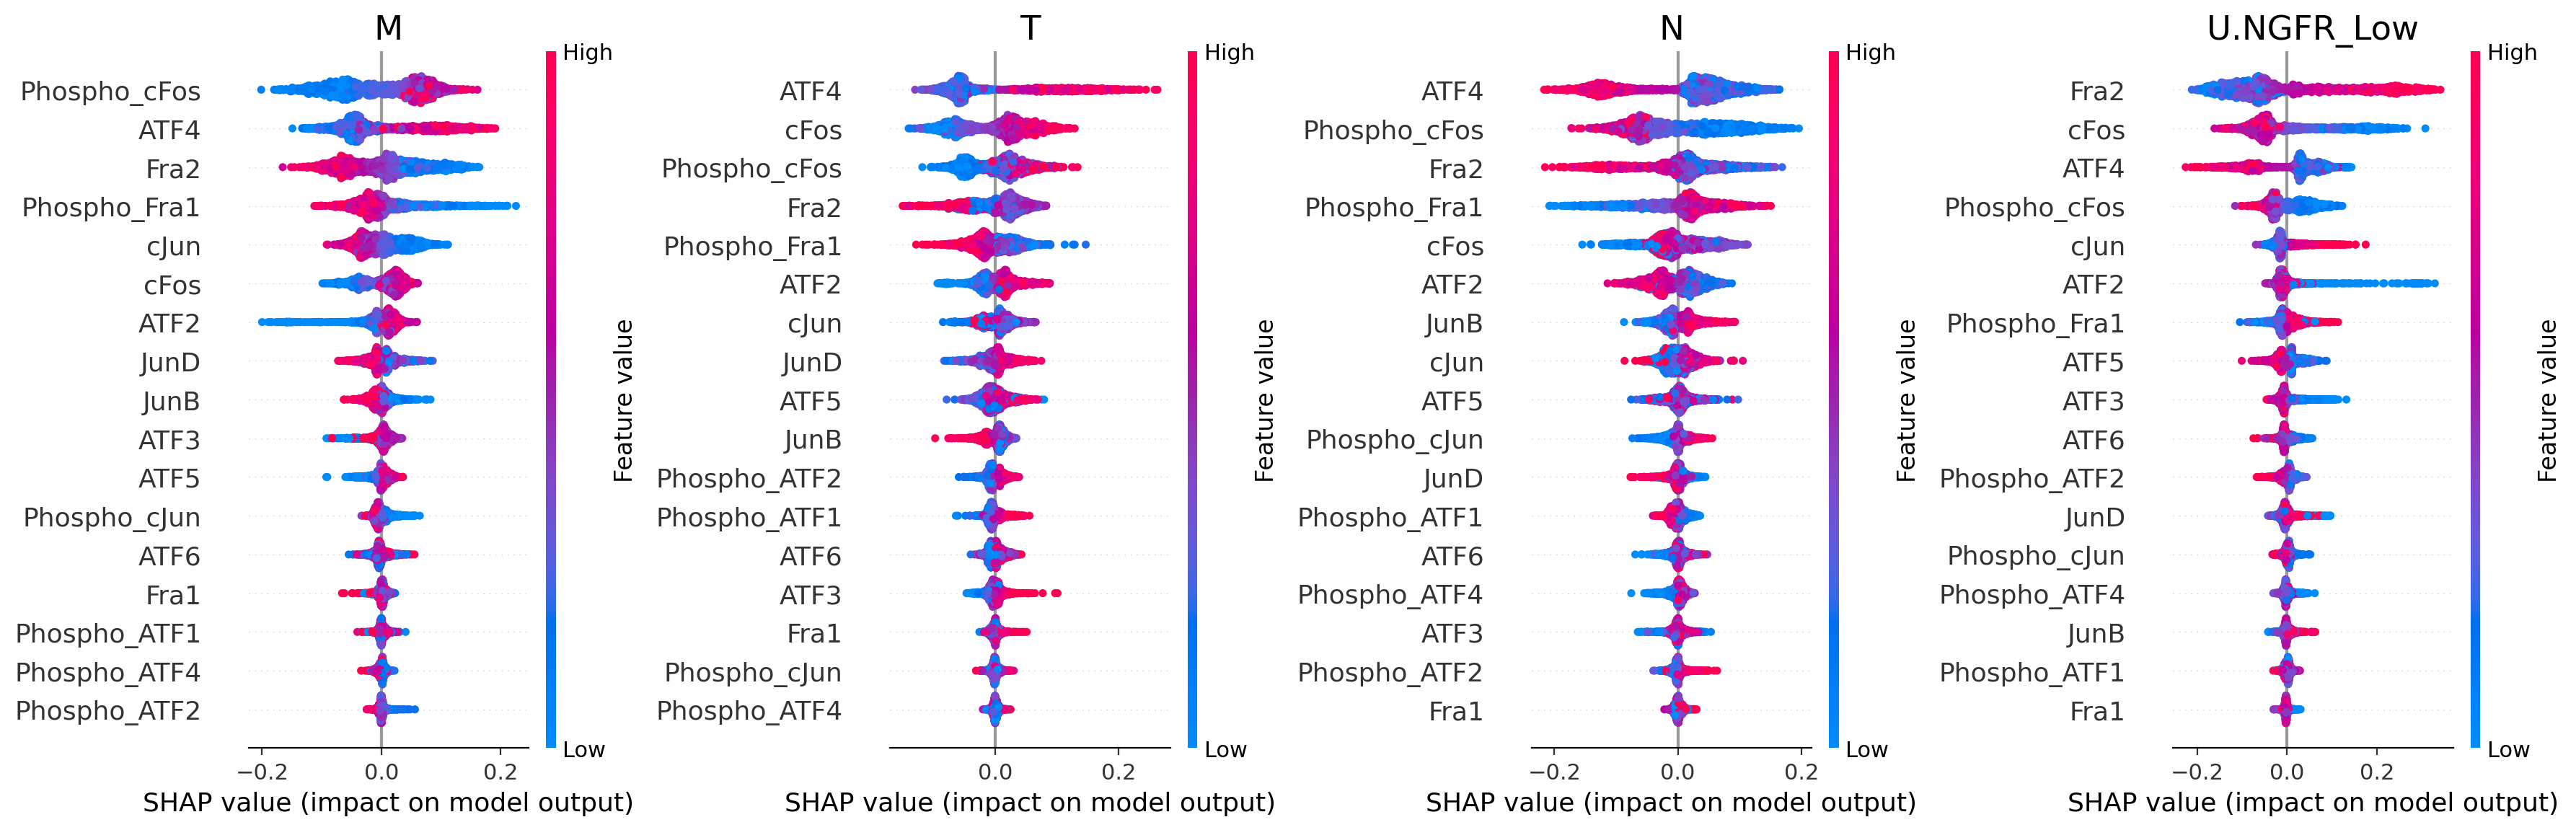

In [41]:
# Local (single-cell) explanations by AP-1(ordered by mean absolute value of the SHAP values for each feature)
plt.subplots(1,4,figsize=(18,6),dpi = 100)
c=1
for i in np.array([0,2,1,3]):
    plt.subplot(1,4,c)
    plt.title(rf.classes_[i])
    shap.summary_plot(shap_values[i], df_X_test_scaled,show=False,plot_size = None)
    c+=1
plt.tight_layout()     
# plt.show()

plt.savefig('SHAP-local-importance_M-T-N-U.pdf', format='pdf')

### 7. Evaluate performance of random forest models that include varying number of top AP-1

In [43]:
#Get sorted list (by mean absolute shap values) of AP-1s for each class
nclass = 4
df_s= {}

c=0
for i in [0,2,1,3]:
    mean_abs_shap = np.abs(shap_values[i]).mean(0)
    
    df = pd.DataFrame(data = list(zip(AP1s, mean_abs_shap)), 
                    columns=['AP-1','mean abs shap'])
    df.sort_values(by= 'mean abs shap', ascending=False,inplace=True)
    df.reset_index(drop=False, inplace=True)
    df_s[c] = df
    c+=1
df_mas= pd.concat(df_s,axis = 1)
df_mas

0                                 1                                 2  \
   index          AP-1 mean abs shap index          AP-1 mean abs shap index   
0      1  Phospho_cFos      0.063466    13          ATF4      0.076911    13   
1     13          ATF4      0.061616     0          cFos      0.048754     1   
2      4          Fra2      0.051350     1  Phospho_cFos      0.036195     4   
3      3  Phospho_Fra1      0.031679     4          Fra2      0.033041     3   
4      5          cJun      0.030361     3  Phospho_Fra1      0.027473     0   
5      0          cFos      0.027927    10          ATF2      0.021086    10   
6     10          ATF2      0.018829     5          cJun      0.016936     7   
7      8          JunD      0.015942     8          JunD      0.015758     5   
8      7          JunB      0.011572    15          ATF5      0.015647    15   
9     12          ATF3      0.010439     7          JunB      0.012468     6   
10    15          ATF5      0.009554    11  Phospho_ATF2      0.009550     8   
11     6  Phospho_cJun      0.008808     9  Phospho_ATF1      0.009316     9   
12    16          ATF6      0.008781    16          ATF6      0.008933    16   
13     2          Fra1      0.005464    12          ATF3      0.008607    14   
14     9  Phospho_ATF1      0.004710     2          Fra1      0.005150    12   
15    14  Phospho_ATF4      0.004479     6  Phospho_cJun      0.004286    11   
16    11  Phospho_ATF2      0.003810    14  Phospho_ATF4      0.003494     2   

                                   3                              
            AP-1 mean abs shap index          AP-1 mean abs shap  
0           ATF4      0.075278     4          Fra2      0.112509  
1   Phospho_cFos      0.063017     0          cFos      0.074696  
2           Fra2      0.046386    13          ATF4      0.062600  
3   Phospho_Fra1      0.044940     1  Phospho_cFos      0.035086  
4           cFos      0.032426     5          cJun      0.024488  
5           ATF2      0.029555    10          ATF2      0.019519  
6           JunB      0.019255     3  Phospho_Fra1      0.018205  
7           cJun      0.017320    15          ATF5      0.018111  
8           ATF5      0.013403    12          ATF3      0.014796  
9   Phospho_cJun      0.011868    16          ATF6      0.011492  
10          JunD      0.008561    11  Phospho_ATF2      0.010645  
11  Phospho_ATF1      0.008520     8          JunD      0.010163  
12          ATF6      0.008257     6  Phospho_cJun      0.006812  
13  Phospho_ATF4      0.008246    14  Phospho_ATF4      0.006704  
14          ATF3      0.007706     7          JunB      0.006669  
15  Phospho_ATF2      0.006147     9  Phospho_ATF1      0.005241  
16          Fra1      0.004222     2          Fra1      0.004221

In [ ]:
scaler = StandardScaler()

test_scores = np.zeros([len(AP1s),3])
feature_list = []
for r in range(len(AP1s)):
    ml = df_mas[0,'AP-1'][0:r+1]
    tl = df_mas[1,'AP-1'][0:r+1]
    nl = df_mas[2,'AP-1'][0:r+1]
    ul = df_mas[3,'AP-1'][0:r+1]
    
    ap1_list = list(set().union(ml,tl,nl,ul))
    feature_list.append(ap1_list)
    #feature_list = [feature_list,ap1_list]
    print(ap1_list)
    X_train_scaled = scaler.fit_transform(X_train[ap1_list])
    X_test_scaled = scaler.transform(X_test[ap1_list])

    rf = RandomForestClassifier(max_depth=max_depth_opt,
                                n_estimators = n_estimators_opt,
                                random_state = seed_id,
                                n_jobs=-1)

    rf.fit(X_train_scaled,y_train)


    #Calculate performance
    test_accuracy = accuracy_score(y_test, rf.predict(X_test_scaled))
    
    print("%d features - Accuracy: %0.3f" % (r+1, test_accuracy))

    y_pred_mat = label_binarize(rf.predict(X_test_scaled),classes = ["M","T","N","U.NGFR_Low"])
    y_test_mat = label_binarize(y_test,classes = ["M","T","N","U.NGFR_Low"])
    test_auc = roc_auc_score(y_test_mat, y_pred_mat,multi_class='ovr')

    
    print("%d features - ROC AUC: %0.3f" % (r+1, test_auc))
    print("-----------------------")
    
    test_scores[r,0] = test_accuracy
    test_scores[r,1] = test_auc
    test_scores[r,2] = len(ap1_list)
df_test_scores = pd.DataFrame(data = test_scores, columns = ["Accuracy", "ROC AUC","Number of Features"])
df_test_scores["Features"] = feature_list

In [132]:
#Save performance
df_test_scores["Features"] = feature_list
df_test_scores.to_csv('RF_Test_Data_Performance.csv')
df_test_scores

Accuracy   ROC AUC  Number of Features  \
0     0.5675  0.711644                 3.0   
1     0.5935  0.728995                 4.0   
2     0.5935  0.728995                 4.0   
3     0.6480  0.765325                 5.0   
4     0.6675  0.778288                 6.0   
5     0.6910  0.793970                 7.0   
6     0.6920  0.794656                 8.0   
7     0.7210  0.813974                10.0   
8     0.7215  0.814331                11.0   
9     0.7310  0.820659                13.0   
10    0.7310  0.820648                14.0   
11    0.7225  0.814978                15.0   
12    0.7225  0.814978                15.0   
13    0.7375  0.824988                17.0   
14    0.7375  0.824988                17.0   
15    0.7375  0.824988                17.0   
16    0.7375  0.824988                17.0   

                                             Features  
0                          [Fra2, Phospho_cFos, ATF4]  
1                    [Fra2, Phospho_cFos, cFos, ATF4]  
2                    [Fra2, Phospho_cFos, cFos, ATF4]  
3      [Phospho_cFos, Fra2, Phospho_Fra1, cFos, ATF4]  
4   [Phospho_cFos, cJun, Fra2, Phospho_Fra1, cFos,...  
5   [Phospho_cFos, cJun, ATF2, Fra2, Phospho_Fra1,...  
6   [Phospho_cFos, JunB, cJun, ATF2, Fra2, Phospho...  
7   [Phospho_cFos, JunD, JunB, cJun, ATF2, Fra2, P...  
8   [Phospho_cFos, JunD, JunB, ATF3, cJun, ATF2, F...  
9   [Phospho_cFos, JunD, Phospho_cJun, JunB, ATF3,...  
10  [Phospho_cFos, JunD, Phospho_cJun, JunB, ATF3,...  
11  [Phospho_cFos, JunD, Phospho_cJun, JunB, ATF3,...  
12  [Phospho_cFos, JunD, Phospho_cJun, JunB, ATF3,...  
13  [Phospho_cFos, JunD, Phospho_cJun, JunB, ATF3,...  
14  [Phospho_cFos, JunD, Phospho_cJun, JunB, ATF3,...  
15  [Phospho_cFos, JunD, Phospho_cJun, JunB, ATF3,...  
16  [Phospho_cFos, JunD, Phospho_cJun, JunB, ATF3,...

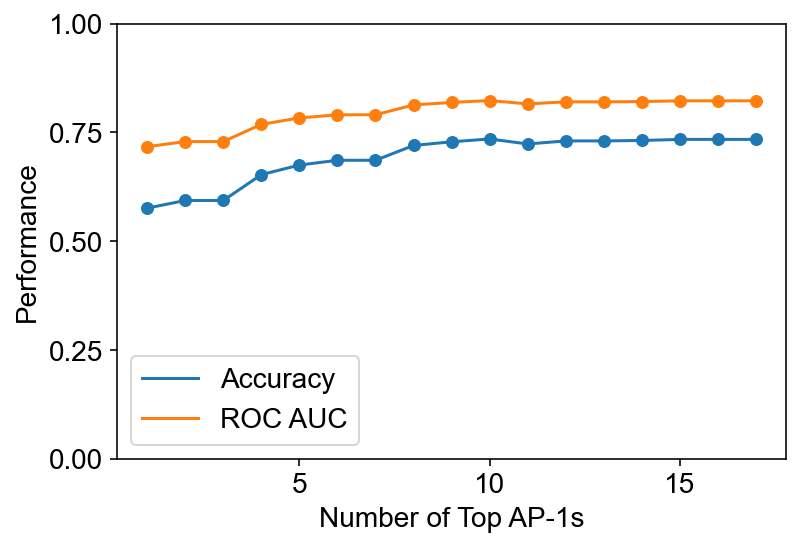

In [267]:
g = sns.scatterplot(data = df_test_scores, x = df_test_scores.index+1, y = df_test_scores["Accuracy"],s = 50)
sns.lineplot(data = df_test_scores, x = df_test_scores.index+1, y = df_test_scores["Accuracy"],label = "Accuracy")
sns.scatterplot(data = df_test_scores, x = df_test_scores.index+1, y = df_test_scores["ROC AUC"],s = 50)
sns.lineplot(data = df_test_scores, x = df_test_scores.index+1, y = df_test_scores["ROC AUC"],label = "ROC AUC")
g.set(ylim=(0, 1),xlabel='Number of Top AP-1s', ylabel='Performance')
sns.set(font_scale=2)
sns.set_style("ticks")


plt.savefig('Model_Performance_Select_Top_AP-1.pdf', format='pdf')